Project 4: Natural Language Processing and Unsupervised Learning<br/>

In this notebook, I do exploratory data analysis on my reddit r/medicine 2020 post data. I want to explore the following questions:<br/>

1. How often are the terms "coronavirus", "pandemic", and "covid" mentioned every month of 2020?

2. What are the top 5 words written in reddit r/medicine posts each month of 2020?

# Table of Contents
1. [Imports](#section1)
2. [Getting Post Data from SQL Database](#section2)
3. [EDA](#section3)

<a id='section1'></a>

### 1. Imports

In [2]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# access my SQL database
import json
import psycopg2 as pg

# NLP preprocessing
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English

# word analysis
from collections import Counter
from nltk.corpus import stopwords
from collections import defaultdict

<a id='section2'></a>

### 2. Getting Post Data from SQL Database

In [3]:
# Postgres info to connect

connection_args = {
                   'host': 'localhost', # we are connecting to our local version of psql
                   'dbname': 'reddit_medicine', # DB we are connecting to
                   'port': 5432, # port we opened
                   'password': '',
                   'user': 'postgres'
                   }

In [4]:
def connect_to_postgres(connection_args):
    '''
    Connect to PostgreSQL database server
    
    Parameters:
    -----------
    - connection_args (dict): dictionary with information needed to connect to the postgreSQL database
    
    Returns:
    --------
    - connection (psycopg2 connection object): the connection to the postgreSQL database
    '''
    connection = None
    try:
        connection = pg.connect(**connection_args)
    except (Exception, pg.DatabaseError) as error:
        print(error)
    
    return connection

In [5]:
connection = connect_to_postgres(connection_args)

There are some posts made in the r/medicine subreddit that are repeated many times. This includes Covid Megathreads and Weekly Careers Threads. In these posts, the post title and submission text are almost exactly the same except for a change in dates. I'm interesting in looking at unique posts made in the r/medicine subreddit, so I decided to exclude these repetitive posts.

In [6]:
# exclude megathreads with repetitive post titles and submissions
reddit_query = "SELECT * FROM submissions \
                WHERE title NOT LIKE 'Megathread:%' \
                AND title NOT LIKE 'Megathread #%' \
                AND title NOT LIKE 'Weekly Careers Thread';"

reddit_df = pd.read_sql(reddit_query, connection)
reddit_df.shape

(1349, 10)

My reddit_df DataFrame has 1400 rows. I collected the top 200 posts from reddit r/medicine for each month of 2020 from January to July. Thus, there are 200 posts from January, 200 posts from February, etc. However, because I am excluding the megathreads and careers thread, I am reducing the total amount of posts in my dataframe from 1400 to 1349.

In [7]:
reddit_df.head()

,post_id,author,created_utc,month,title,submission_text,score,num_comments,stickied,url
0,ff8hns,mcgianni,1583647410,3,"Testimony of a surgeon working in Bergamo, in ...",«In one of the non-stop e-mails that I receive...,1,571,False,https://www.reddit.com/r/medicine/comments/ff8...
1,figd1n,indianola,1584181842,3,I posted a while back seeking a clinical portr...,Got this being passed around my circle of phys...,1,393,False,https://www.reddit.com/r/medicine/comments/fig...
2,fg2rze,Light151,1583791324,3,Anyone else have colleagues who are still sayi...,I have been trying to raise awareness that our...,1,386,False,https://www.reddit.com/r/medicine/comments/fg2...
3,fi78id,dyingalonewithcats,1584135092,3,Latest CDC updates: best case/worst case scena...,,1,336,False,https://www.reddit.com/r/medicine/comments/fi7...
4,fdznn0,half-taught-wrong,1583433075,3,[Serious] What is your plan if you or someone ...,I am trying to learn from medical colleagues. ...,1,322,False,https://www.reddit.com/r/medicine/comments/fdz...


<a id='section3'></a>

### 3. EDA

I want to explore the following about my data:
* How often are the terms "coronavirus", "pandemic", "covid", etc. mentioned each month? Have they increased in frequency over the course of 2020?
* What are the top 5 words said per month (not including stop words)?

In [8]:
reddit_df["full_text"] = reddit_df["title"] + ' ' + reddit_df["submission_text"]

The full text includes the post title and the submission text. I want to do some basic cleaning (removing punctuation, links, etc.) before doing exploratory data analysis.

In [9]:
def cleaning_function(corpus, regex_patterns, char_space, char_no_space):
    '''
    With this cleaning function, I remove special characters, certain types of punctuation, hyperlinks, and any
    text used for formatting the post in a markdown format.
    
    Parameters:
    ----------
    - corpus (string): string of reddit posts
    - regex_patterns (list): list of regex patterns to remove
    - char_space (string): characters to replace with a space
    - char_no_space (string): characters to replace with no space
    
    Returns:
    --------
    - cleaned_corpus (string): clean string of reddit posts
    
    '''
    cleaned_corpus = str(corpus)
    for pattern in regex_patterns:
        cleaned_corpus = re.sub(pattern, ' ', cleaned_corpus)
    
    for char in char_space:
        cleaned_corpus = cleaned_corpus.replace(char, ' ')
    
    for char in char_no_space:
        cleaned_corpus = cleaned_corpus.replace(char, '')
    
    cleaned_corpus = cleaned_corpus.lower()
    
    return cleaned_corpus

In [10]:
regex_patterns = ['\n', '\t', 'https?:\/\/\S+', '&\S*', \
                  '[%s]' % re.escape(string.punctuation), \
                  '\\xa0', '[__]{2,}', '[\d]+', 'χ', '®']
char_space = '^*>|[]()",°#’'
char_no_space = '/-\\'

In [11]:
reddit_df["cleaned_text"] = reddit_df["full_text"].apply(lambda x:
                            cleaning_function(x, regex_patterns, char_space, char_no_space))

In [12]:
def count_word_mentions(word_list, text):
    '''
    Count how many times a word in the word list appears in the text.
    
    Parameters:
    ----------
    - word_list (list): list of words to count
    - text (string): the text to search through
    
    Returns:
    --------
    - counter (int): count of how many times the words appeared in the text
    
    '''
    counter = 0
    tokenize_text = word_tokenize(text)
    
    for word in tokenize_text:
        if word in word_list:
            counter += 1
            
    return counter

In [13]:
word_list = ['coronavirus', 'covid', 'pandemic']
reddit_df['pandemic_count'] = reddit_df["cleaned_text"].apply(lambda x: count_word_mentions(word_list, x))

In [14]:
month_df = (reddit_df.groupby('month')[["cleaned_text", "pandemic_count"]]
                     .agg({"cleaned_text": (' '.join), "pandemic_count":"sum"})
                     .reset_index()
           )
month_df          

,month,cleaned_text,pandemic_count
0,1,wearable monitoring technology helps nurses av...,8
1,2,for my us colleagues with heavy medical educat...,42
2,3,testimony of a surgeon working in bergamo in ...,276
3,4,chiropractors are feeding their patients fake ...,217
4,5,what phrase in medicine grinds your gears i fi...,90
5,6,weve just given up on covid havent we i am ju...,114
6,7,does anyone else feel that so many people who ...,123


In [15]:
def count_words(text):
    '''
    Count the number of words in text
    '''
    tokenize_text = word_tokenize(text)
    return len(tokenize_text)

In [16]:
month_df["word_count"] = month_df["cleaned_text"].apply(count_words)
month_df

,month,cleaned_text,pandemic_count,word_count
0,1,wearable monitoring technology helps nurses av...,8,21698
1,2,for my us colleagues with heavy medical educat...,42,26374
2,3,testimony of a surgeon working in bergamo in ...,276,36259
3,4,chiropractors are feeding their patients fake ...,217,47359
4,5,what phrase in medicine grinds your gears i fi...,90,20962
5,6,weve just given up on covid havent we i am ju...,114,32697
6,7,does anyone else feel that so many people who ...,123,23112


In [17]:
month_df["pandemic_percent"] = month_df["pandemic_count"] / month_df["word_count"] * 100
month_df

,month,cleaned_text,pandemic_count,word_count,pandemic_percent
0,1,wearable monitoring technology helps nurses av...,8,21698,0.036870
1,2,for my us colleagues with heavy medical educat...,42,26374,0.159248
2,3,testimony of a surgeon working in bergamo in ...,276,36259,0.761190
3,4,chiropractors are feeding their patients fake ...,217,47359,0.458202
4,5,what phrase in medicine grinds your gears i fi...,90,20962,0.429348
5,6,weve just given up on covid havent we i am ju...,114,32697,0.348656
6,7,does anyone else feel that so many people who ...,123,23112,0.532191


In [35]:
# for viewing the types of available fonts
import matplotlib.font_manager
set([f.name for f in matplotlib.font_manager.fontManager.ttflist])

{'.Aqua Kana',
 '.Arabic UI Display',
 '.Arabic UI Text',
 '.Helvetica Neue DeskInterface',
 '.Keyboard',
 '.LastResort',
 '.New York',
 '.SF Compact Display',
 '.SF Compact Rounded',
 '.SF Compact Text',
 '.SF NS Display Condensed',
 '.SF NS Mono',
 '.SF NS Rounded',
 '.SF NS Text Condensed',
 'Al Bayan',
 'Al Nile',
 'Al Tarikh',
 'American Typewriter',
 'Andale Mono',
 'Apple Braille',
 'Apple Chancery',
 'Apple SD Gothic Neo',
 'Apple Symbols',
 'AppleGothic',
 'AppleMyungjo',
 'Arial',
 'Arial Black',
 'Arial Hebrew',
 'Arial Narrow',
 'Arial Rounded MT Bold',
 'Arial Unicode MS',
 'Athelas',
 'Avenir',
 'Avenir Next',
 'Avenir Next Condensed',
 'Ayuthaya',
 'Baghdad',
 'Bangla MN',
 'Bangla Sangam MN',
 'Baskerville',
 'Beirut',
 'Big Caslon',
 'Bodoni 72',
 'Bodoni 72 Oldstyle',
 'Bodoni 72 Smallcaps',
 'Bodoni Ornaments',
 'Bradley Hand',
 'Brush Script MT',
 'Chalkboard',
 'Chalkboard SE',
 'Chalkduster',
 'Charter',
 'Cochin',
 'Comic Sans MS',
 'Copperplate',
 'Corsiva Hebre

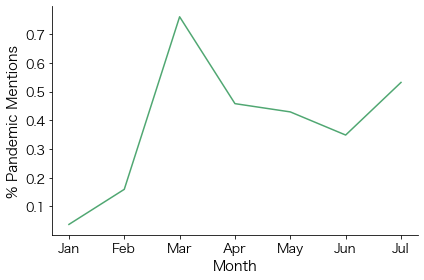

In [18]:
# plot the number of times a pandemic related word is mentioned in 2020
sns.lineplot(x=month_df["month"], y=month_df["pandemic_percent"], color= '#50a772',
             data=month_df)
sns.despine(top=True, right=True)
plt.xlabel("Month", fontname="Hiragino Sans GB", fontsize=14)
plt.ylabel("% Pandemic Mentions", fontname="Hiragino Sans GB", fontsize=14)
plt.xticks(ticks=[1,2,3,4,5,6,7], labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"], fontname="Hiragino Sans GB", fontsize=13)
plt.yticks(fontname="Hiragino Sans GB", fontsize=13)
plt.tight_layout()
plt.savefig(f'images/pandemic_mentions.png', format='png', dpi=600, transparent=True);

In [22]:
def remove_stop_words(text):
    '''
    Remove stop words and short words (like "I") from text
    '''
    # noticed there were some common terms that were widely used and don't have as much meaning
    add_stop_words = ["patient", "patients", "hospital", "medical", "physician", "physicians", "people", "doctors",
                      "care", "practice", "medicine", "time", "years", "year"]
    
    stop_words = stopwords.words('english')
    stop_words.extend(add_stop_words)
    
    tokenize_text = word_tokenize(text)
    
    cleaned_words = []
    
    for word in tokenize_text:
        # remove any words less than 3 characters in length
        if word not in stop_words and len(word) > 3:
            cleaned_words.append(word)
    return ' '.join(cleaned_words)

In [23]:
def pos_filter(text, pos_list):
    '''
    Filter text based on part of speech (pos) using nltk.pos_tag
    
    Parameters:
    ----------
    - text (string): the text to filter on
    - pos_list (list): list of parts of speech (these strings correspond to nltk part of speech abbreviations)
    
    Returns:
    --------
    a string that only contains words that are a certain part of speech
    
    '''
    tokenize_text = word_tokenize(text)
    pos_text = pos_tag(tokenize_text)
    pos_filter = []
    
    for word, pos in pos_text:
        for part_of_speech in pos_list:
            if part_of_speech in pos:
                pos_filter.append(word)
    
    return ' '.join(pos_filter)

In [25]:
reddit_df["cleaned_text"] = reddit_df["cleaned_text"].apply(remove_stop_words)

In [26]:
# only grab nouns, verbs, and adjectives
pos_list = ["NN", "VB", "JJ"] # abbreviations from nltk
reddit_df["noun_verb_adj"] = reddit_df["cleaned_text"].apply(lambda x: pos_filter(x, pos_list))

In [27]:
# only grab nouns
pos_list = ["NN"] # abbreviation from nltk
reddit_df["nouns"] = reddit_df["cleaned_text"].apply(lambda x: pos_filter(x, pos_list))

In [53]:
reddit_df.head()

,post_id,author,created_utc,month,title,submission_text,score,num_comments,stickied,url,full_text,cleaned_text,pandemic_count,noun_verb_adj,nouns
0,ff8hns,mcgianni,1583647410,3,"Testimony of a surgeon working in Bergamo, in ...",«In one of the non-stop e-mails that I receive...,1,571,False,https://www.reddit.com/r/medicine/comments/ff8...,"Testimony of a surgeon working in Bergamo, in ...",testimony surgeon working bergamo heart italys...,4,testimony surgeon working bergamo heart italys...,testimony surgeon heart italys coronavirus sto...
1,figd1n,indianola,1584181842,3,I posted a while back seeking a clinical portr...,Got this being passed around my circle of phys...,1,393,False,https://www.reddit.com/r/medicine/comments/fig...,I posted a while back seeking a clinical portr...,posted back seeking clinical portrait caring c...,7,posted seeking clinical portrait caring covid ...,portrait covid today please staff circle worke...
2,fg2rze,Light151,1583791324,3,Anyone else have colleagues who are still sayi...,I have been trying to raise awareness that our...,1,386,False,https://www.reddit.com/r/medicine/comments/fg2...,Anyone else have colleagues who are still sayi...,anyone else colleagues still saying dont panic...,0,anyone colleagues saying dont panic trying rai...,anyone colleagues panic hospital system things...
3,fi78id,dyingalonewithcats,1584135092,3,Latest CDC updates: best case/worst case scena...,,1,336,False,https://www.reddit.com/r/medicine/comments/fi7...,Latest CDC updates: best case/worst case scena...,latest updates best case worst case scenarios ...,1,latest updates case worst case scenarios covid,updates case case scenarios
4,fdznn0,half-taught-wrong,1583433075,3,[Serious] What is your plan if you or someone ...,I am trying to learn from medical colleagues. ...,1,322,False,https://www.reddit.com/r/medicine/comments/fdz...,[Serious] What is your plan if you or someone ...,serious plan someone family sick regarding cov...,4,serious plan someone family sick regarding cov...,plan someone family covid colleagues reddit se...


What are the top words said per month? Look at the top nouns, verbs, and adjective words. If the words don't have as much meaning, look at just the top nouns

In [28]:
month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"]

top_words_per_month = defaultdict(list) # top nouns, verbs, adjectives per month

# loop through months from Jan (1) to July (7)
for i in range(1, 8):
    monthly_posts = reddit_df[reddit_df["month"] == i].copy()
    month_full_text = ' '.join(monthly_posts["noun_verb_adj"].to_list())
    tokenize_text = word_tokenize(month_full_text)
    word_counter = Counter(tokenize_text)
    for word, count in word_counter.most_common(5):
        top_words_per_month[month_list[i-1]].append(word)

In [29]:
top_words_per_month

defaultdict(list,
            {'Jan': ['work', 'think', 'know', 'health', 'make'],
             'Feb': ['training', 'residency', 'healthcare', 'health', 'work'],
             'Mar': ['covid', 'masks', 'need', 'going', 'cases'],
             'Apr': ['covid', 'know', 'need', 'test', 'going'],
             'May': ['covid', 'know', 'health', 'make', 'want'],
             'Jun': ['covid', 'know', 'work', 'health', 'public'],
             'Jul': ['covid', 'know', 'anyone', 'work', 'school']})

In [30]:
month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"]

top_nouns_per_month = defaultdict(list) # top nouns per month

# loop through months from Jan (1) to July (7)
for i in range(1, 8):
    monthly_posts = reddit_df[reddit_df["month"] == i].copy()
    month_full_text = ' '.join(monthly_posts["nouns"].to_list())
    tokenize_text = word_tokenize(month_full_text)
    word_counter = Counter(tokenize_text)
    for word, count in word_counter.most_common(5):
        top_nouns_per_month[month_list[i-1]].append(word)

In [31]:
top_nouns_per_month

defaultdict(list,
            {'Jan': ['work', 'health', 'hours', 'doctor', 'week'],
             'Feb': ['health', 'residency', 'doctor', 'work', 'post'],
             'Mar': ['covid', 'masks', 'cases', 'respirators', 'room'],
             'Apr': ['covid', 'test', 'days', 'room', 'work'],
             'May': ['covid', 'health', 'school', 'student', 'pain'],
             'Jun': ['covid', 'work', 'health', 'anyone', 'life'],
             'Jul': ['covid', 'anyone', 'school', 'work', 'data']})